In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import load_model

In [ ]:
dataset = pd.read_csv('./data_mv_set.csv')
dataset.head()

,uuid,exchange,ask_price,ask_whole_lot_volume,ask_lot_volume,bid_price,bid_whole_lot_volume,bid_lot_volume,close_price,close_volume,volume_avg_today,volume_avg_24h,trades_today,trades_24h,low_today,low_24h,high_today,high_24h,opening_price,ts
0,9831925d-f9b1-4fde-9d40-34c5dc222a91,kraken,0.000804,289,289,0.000802,150,150,0.000805,150,94508.35523,176635.0497,1087,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
1,63644912-c186-4a7c-a0fd-739520c879b6,kraken,0.000804,334,334,0.000802,150,150,0.000805,150,103094.91810,176635.0497,1196,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
2,8150086e-98d8-4dd3-91fa-111923a6f78c,kraken,0.000804,289,289,0.000802,150,150,0.000805,150,103094.95470,176635.0497,1198,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
3,6df11107-1be2-4e31-97a6-d20e80431b14,kraken,0.000804,134,134,0.000802,150,150,0.000805,150,103249.37390,176635.0497,1199,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
4,2d2358d9-dec6-49be-b309-33db96b75eaa,kraken,0.000804,134,134,0.000802,150,150,0.000805,150,103279.59390,176635.0497,1200,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487


In [ ]:
del dataset['uuid']
del dataset['exchange']
del dataset['volume_avg_today']
del dataset['volume_avg_24h']
del dataset['trades_today']
del dataset['trades_24h']
del dataset['low_today']
del dataset['low_24h']
del dataset['high_today']
del dataset['high_24h']
del dataset['opening_price']

In [ ]:
dataset.head()

,ask_price,ask_whole_lot_volume,ask_lot_volume,bid_price,bid_whole_lot_volume,bid_lot_volume,close_price,close_volume,ts
0,0.000804,289,289,0.000802,150,150,0.000805,150,25569.50487
1,0.000804,334,334,0.000802,150,150,0.000805,150,25569.50487
2,0.000804,289,289,0.000802,150,150,0.000805,150,25569.50487
3,0.000804,134,134,0.000802,150,150,0.000805,150,25569.50487
4,0.000804,134,134,0.000802,150,150,0.000805,150,25569.50487


In [ ]:
n_train_rows = int(dataset.shape[0]*.8)-1

In [ ]:
train = dataset.iloc[:n_train_rows, :]
test = dataset.iloc[n_train_rows:, :]

In [ ]:
print(train.shape)
print(test.shape)

(26638, 9)
(6661, 9)


In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

In [ ]:
steps = 50
x_train = []
y_train = []
x_test = []
y_test = []

In [ ]:
for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(26538, 50, 9)


In [ ]:
for i in range(steps, test_set_scaled.shape[0]):
    x_test.append(test_set_scaled[i-steps:i, :])
    y_test.append(test_set_scaled[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(6611, 50, 9)


In [ ]:
model = Sequential()

In [ ]:
epochs = 10

model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],9)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=9))
model.compile(loss="mse", optimizer="adam")
model.fit(x_train, y_train, batch_size = 32, epochs = epochs)
model.summary

Epoch 1/10
830/830 [==============================] - 87s 97ms/step - loss: 0.0326
Epoch 2/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0254
Epoch 3/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0232
Epoch 4/10
830/830 [==============================] - 81s 97ms/step - loss: 0.0224
Epoch 5/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0220
Epoch 6/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0219
Epoch 7/10
830/830 [==============================] - 82s 98ms/step - loss: 0.0218
Epoch 8/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0217
Epoch 9/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0217
Epoch 10/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0217


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fc02ed3a3d0>>

In [ ]:
model.save("multiple_features_"+str(steps)+"_steps_"+str(epochs)+"_epochs.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)

207/207 [==============================] - 6s 25ms/step - loss: 0.0172
test loss, test acc: 0.017181774601340294


In [ ]:
y_hat = model.predict(x_test)
y_hat = sc.inverse_transform(y_hat)

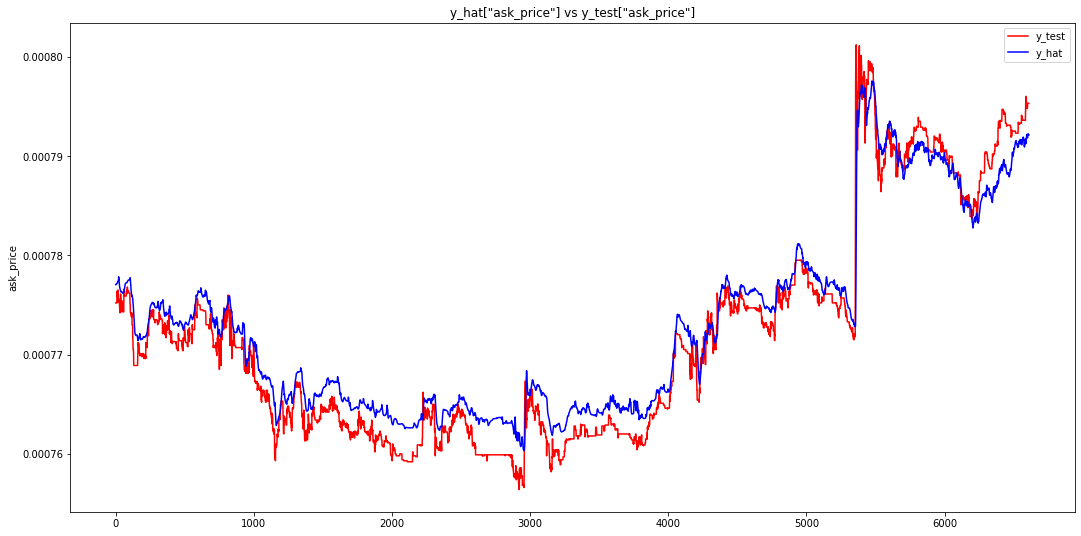

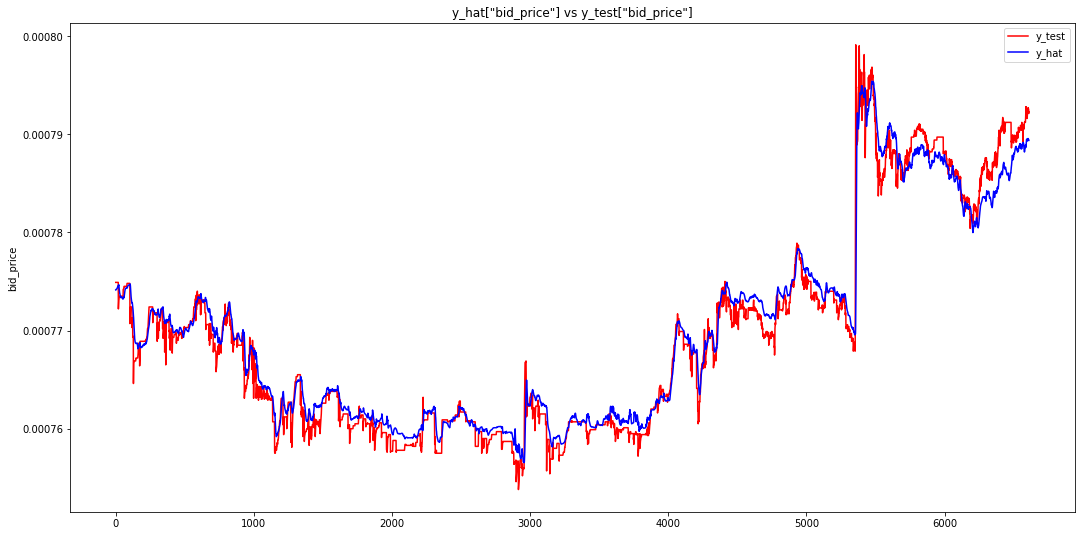

In [ ]:
y_test = test[steps:].reset_index()


plt.figure(figsize = (18,9))
plt.plot(y_test['ask_price'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,0], color = 'blue', label = 'y_hat')
plt.title('y_hat["ask_price"] vs y_test["ask_price"]')
plt.ylabel('ask_price')
plt.legend()
plt.show()


plt.figure(figsize = (18,9))
plt.plot(y_test['bid_price'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,3], color = 'blue', label = 'y_hat')
plt.title('y_hat["bid_price"] vs y_test["bid_price"]')
plt.ylabel('bid_price')
plt.legend()
plt.show()

In [ ]:
def moving_test_window_preds(start, n_future_preds):
    
    
    prediction = [] 
    moving_input_window = []
    
    
    inputs = test.reset_index(drop=True).values
    inputs = sc.transform(inputs)

    moving_input_window.append(inputs[start:(start+steps), :])
    moving_input_window = np.array(moving_input_window)
    moving_input_window = np.reshape(moving_input_window, (moving_input_window.shape[0], moving_input_window.shape[1], 9))
    
    
    for i in range(n_future_preds):
        
        
        y_hat = model.predict(moving_input_window)
        
        
        prediction.append(y_hat[0,:])
        
        
        y_hat = y_hat.reshape(1,1,9) 
        
        
        moving_input_window = np.concatenate((moving_input_window[:,1:,:], y_hat),axis=1)

    prediction = sc.inverse_transform(pd.DataFrame(prediction))
    
    return prediction

In [ ]:
n_future_preds = 20
prediction = moving_test_window_preds(0,n_future_preds)

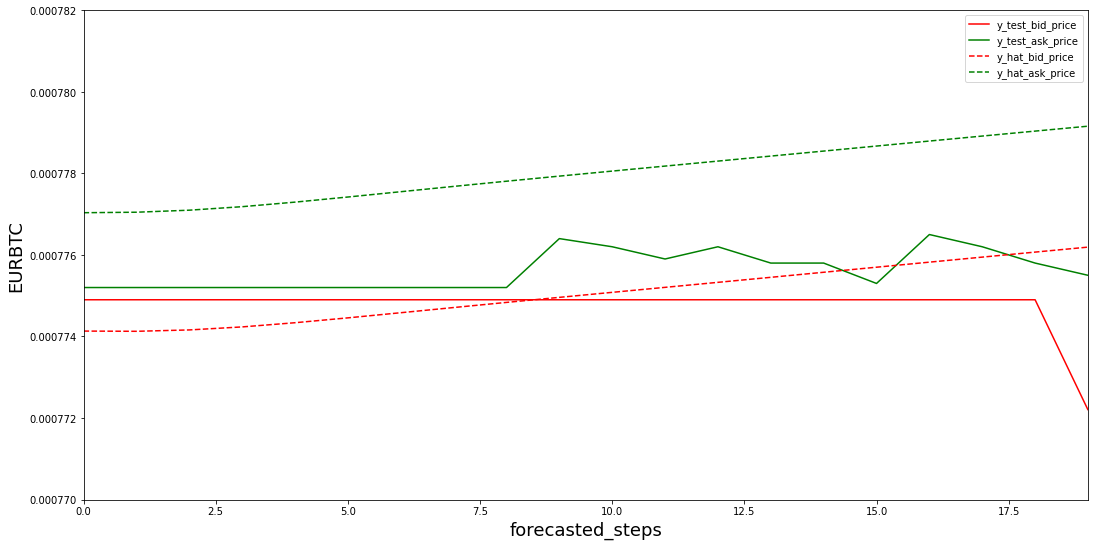

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(y_test["bid_price"], color = 'red', label='y_test_bid_price')
plt.plot(y_test["ask_price"], color = 'green', label='y_test_ask_price')
plt.plot(prediction[:,3], color = 'red', label='y_hat_bid_price', linestyle='--')
plt.plot(prediction[:,0], color = 'green', label='y_hat_ask_price', linestyle='--')
plt.gca().set_xlim(0,prediction.shape[0]-1)
plt.gca().set_ylim(0.00077,0.000782)
plt.xlabel('forecasted_steps', fontsize=18)
plt.ylabel('EURBTC', fontsize=18)
plt.legend()
plt.show()

In [ ]:
def multiple_predictions():
    
    predictions = []
    
    for i in range(0,test.shape[0]-steps,steps):

        y_hat = moving_test_window_preds(i,n_future_preds)
        
        predictions.append(y_hat)
        
    return predictions
    
predictions = multiple_predictions()

In [ ]:
n_future_preds = 20
prediction = moving_test_window_preds(0,n_future_preds)

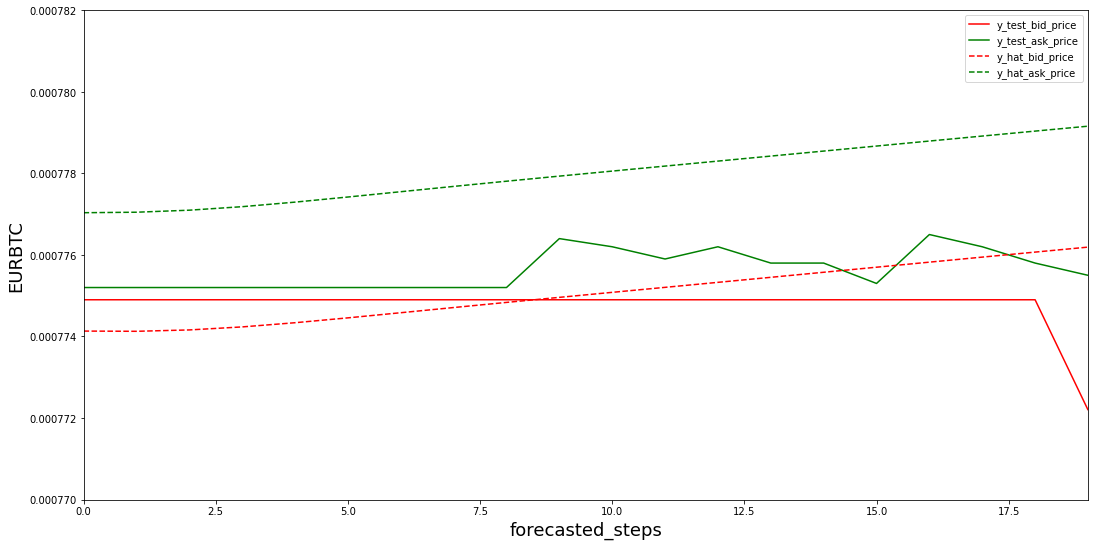

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(y_test["bid_price"], color = 'red', label='y_test_bid_price')
plt.plot(y_test["ask_price"], color = 'green', label='y_test_ask_price')
plt.plot(prediction[:,3], color = 'red', label='y_hat_bid_price', linestyle='--')
plt.plot(prediction[:,0], color = 'green', label='y_hat_ask_price', linestyle='--')
plt.gca().set_xlim(0,prediction.shape[0]-1)
plt.gca().set_ylim(0.00077,0.000782)
plt.xlabel('forecasted_steps', fontsize=18)
plt.ylabel('EURBTC', fontsize=18)
plt.legend()
plt.show()

In [ ]:
def multiple_predictions():
    
    predictions = []
    
    for i in range(0,test.shape[0]-steps,steps):

        y_hat = moving_test_window_preds(i,n_future_preds)
        
        predictions.append(y_hat)
        
    return predictions
    
predictions = multiple_predictions()

In [ ]:
test_data_ask_price_delta_positive_predictions_only = []
prediction_data_ask_price_delta_positive_predictions_only = []

for i, p in enumerate(predictions):
    delta = p[:,0][n_future_preds-1]-p[:,0][0]
    if delta > 0:
        buy = y_test["ask_price"][i+steps]
        sale = y_test["ask_price"][i]
        test_data_ask_price_delta_positive_predictions_only.append(sale-buy)
        prediction_data_ask_price_delta_positive_predictions_only.append(delta)

test_data_ask_price_delta_cumulative_positive_predictions_only = np.cumsum(test_data_ask_price_delta_positive_predictions_only)
prediction_data_ask_price_delta_cumulative_positive_predictions_only = np.cumsum(prediction_data_ask_price_delta_positive_predictions_only)

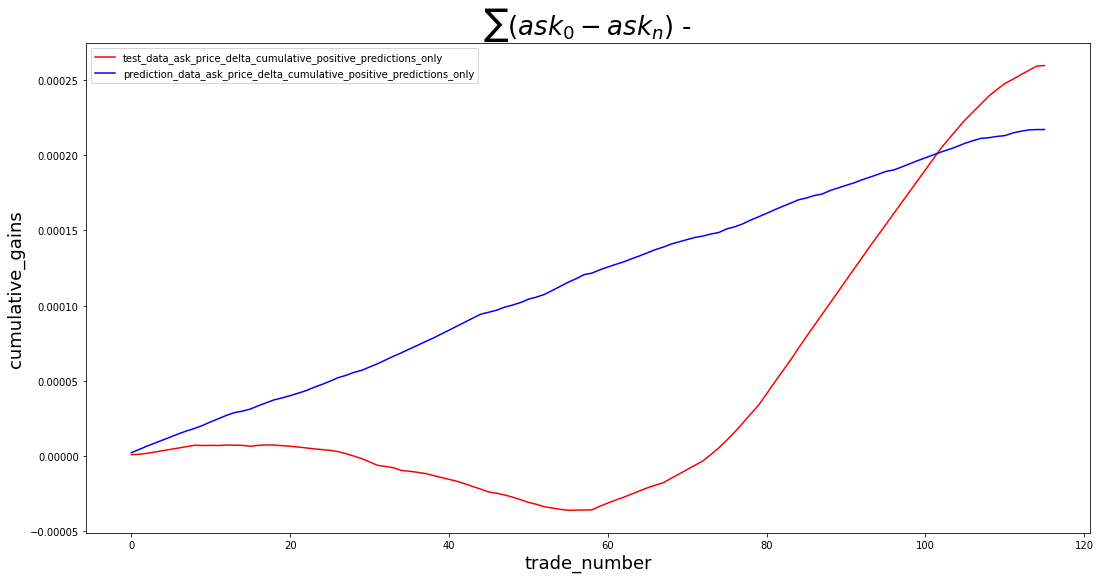

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(test_data_ask_price_delta_cumulative_positive_predictions_only, color = 'red', label='test_data_ask_price_delta_cumulative_positive_predictions_only')
plt.plot(prediction_data_ask_price_delta_cumulative_positive_predictions_only, color = 'blue', label = 'prediction_data_ask_price_delta_cumulative_positive_predictions_only')
plt.title(r'$\sum (ask_0 - ask_n$) - ', fontsize=26)
plt.xlabel('trade_number', fontsize=18)
plt.ylabel('cumulative_gains', fontsize=18)
plt.legend()
plt.show()

In [ ]:
test_data_ask_vs_bid_price_delta_positive_predictions_only = []
prediction_data_ask_vs_bid_price_delta_positive_predictions_only = []

for i, p in enumerate(predictions):
    delta = p[:,0][n_future_preds-1]-p[:,0][0]
    if delta > 0:
        buy = y_test["ask_price"][i+steps]
        sale = y_test["bid_price"][i]
        test_data_ask_vs_bid_price_delta_positive_predictions_only.append(sale-buy)
        prediction_data_ask_vs_bid_price_delta_positive_predictions_only.append(delta)

test_data_ask__vs_bid_price_delta_cumulative_positive_predictions_only = np.cumsum(test_data_ask_vs_bid_price_delta_positive_predictions_only)
prediction_data_ask_vs_bid_price_delta_cumulative_positive_predictions_only = np.cumsum(prediction_data_ask_vs_bid_price_delta_positive_predictions_only)

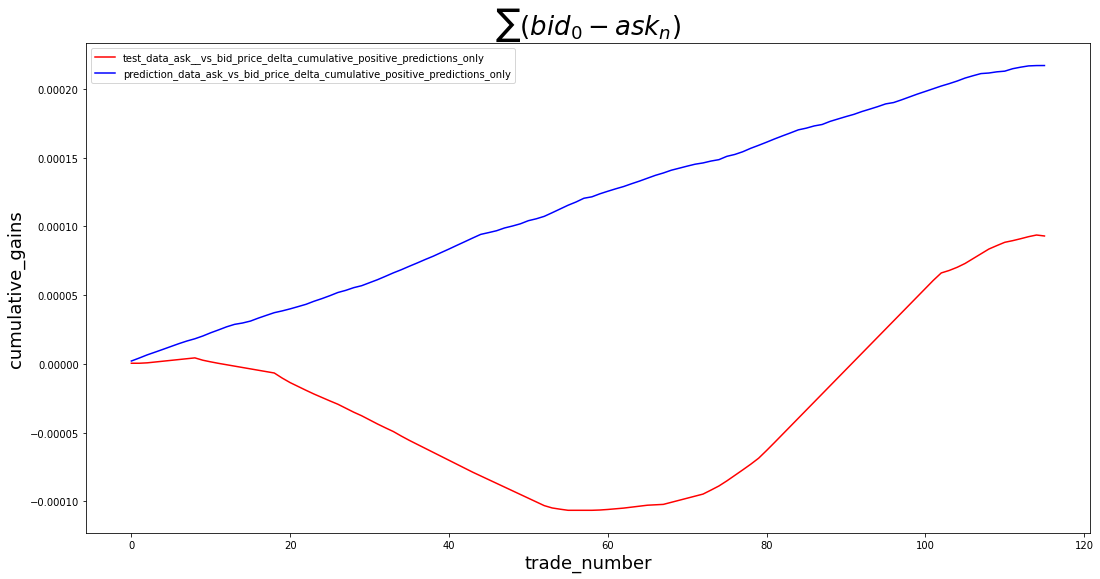

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(test_data_ask__vs_bid_price_delta_cumulative_positive_predictions_only, color = 'red', label='test_data_ask__vs_bid_price_delta_cumulative_positive_predictions_only')
plt.plot(prediction_data_ask_vs_bid_price_delta_cumulative_positive_predictions_only, color = 'blue', label = 'prediction_data_ask_vs_bid_price_delta_cumulative_positive_predictions_only')
plt.title(r'$\sum (bid_0 - ask_n$)', fontsize=26)
plt.xlabel('trade_number', fontsize=18)
plt.ylabel('cumulative_gains', fontsize=18)
plt.legend()
plt.show()

In [ ]:
test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only = []
prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only = []
taker_fee = 0.001

for i, p in enumerate(predictions):
    buy_predict = p[:,0][0]*(1+taker_fee)
    sell_predict = p[:,0][n_future_preds-1]*(1-taker_fee)
    delta = sell_predict - buy_predict
    if delta > 0:
        buy = y_test["ask_price"][i+steps]*(1+taker_fee)
        sale = y_test["bid_price"][i]*(1-taker_fee)
        test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only.append(sale-buy)
        prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only.append(delta)

test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only = np.cumsum(test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only)
prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only = np.cumsum(prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only)

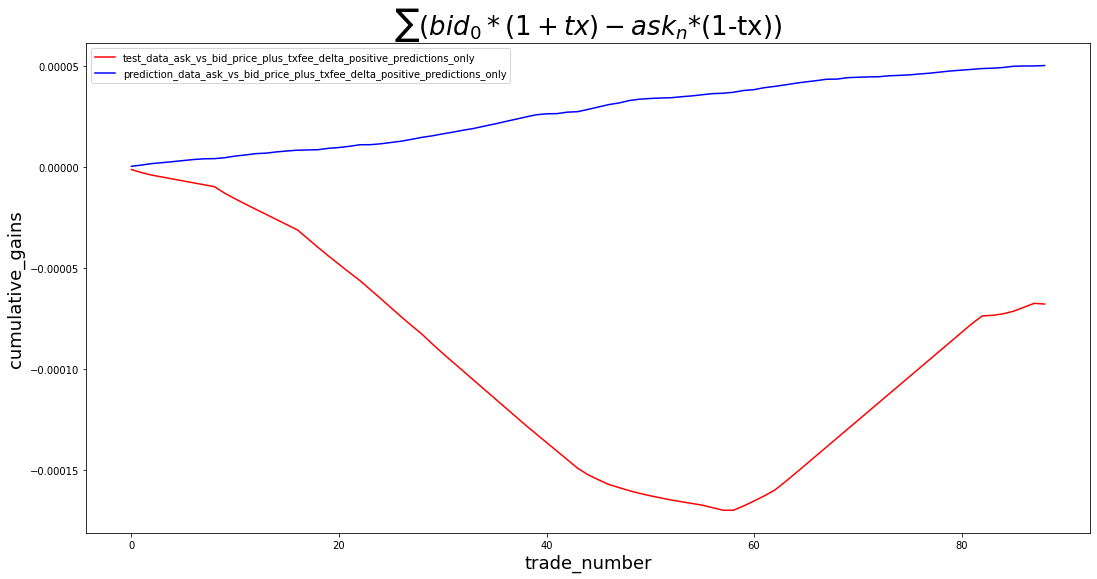

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only, color = 'red', label='test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only')
plt.plot(prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only, color = 'blue', label = 'prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only')
plt.title(r'$\sum (bid_0*(1+tx) - ask_n$*(1-tx))', fontsize=26)
plt.xlabel('trade_number', fontsize=18)
plt.ylabel('cumulative_gains', fontsize=18)
plt.legend()
plt.show()